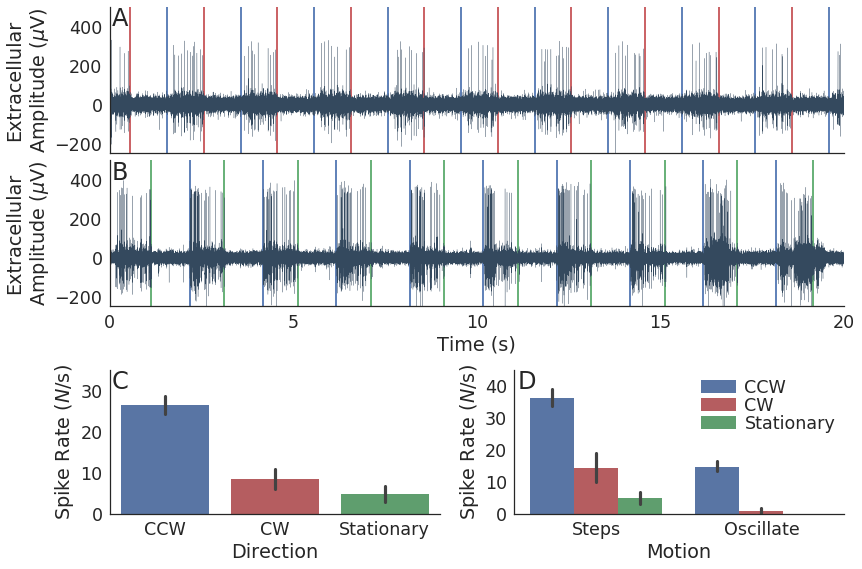

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mne import pick_channels
from mne.io import Raw
from pandas import read_csv
from utilities import *
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot representative timecourses.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Open canvas for plotting.
fig = plt.figure(figsize=(12,8))

## Initialize top-half of plots.
gs = gridspec.GridSpec(2, 1)
gs.update(left=0.125, right=0.975, bottom=0.46,  top=0.98, hspace=0.05)

for i, f, m, d, s in zip(range(2), ['17o18007', '17o18014'], ['Oscillate','Steps'], ['CCW', 'CCW'],['A','B']):

    ## Load data.
    raw = Raw('raw/%s_raw.fif' %f, preload=True, verbose=False)

    ## Filter data.
    picks = pick_channels(raw.ch_names, include=['h1'])
    raw = raw.filter(300, 3000, picks=picks, phase='zero', verbose=False)

    ## Crop first 100ms (remove artifact).
    raw = raw.crop(0.1, tmax=None)

    ## Extract recording.
    data, times = raw.get_data(return_times=True)
    voltage, stimulus = data
    voltage *= 1e6

    ## Detect events. 
    if m == 'Steps':
        events = find_step_events(stimulus, d, raw.info['sfreq'], 5, 0.5, 5e-5)
    elif m == 'Oscillate':
        events = find_oscillation_events(stimulus, d, raw.info['sfreq'], 5)

    ## Plot.
    ax = plt.subplot(gs[i])
    ax.plot(times, voltage, linewidth=0.25, color='#34495e')

    ## Add event markers.
    y1, y2 = -250, 500
    for n, color in enumerate(['#55a868', '#4c72b0', '#c44e52']):
        ax.vlines(times[events[events[:,-1]==n, 0]], y1, y2, linewidth=1.75, color=color)   

     ## Add information.
    ax.set(xlim=(20,40), xticks=[], ylim=(y1,y2), yticks=np.arange(-200,500,200), 
           ylabel='Extracellular\n' + r'Amplitude ($\mu$V)')
    ax.text(20.05, y2, s, va='top', ha='left', fontsize=24)
    
ax.set(xticks=np.arange(20,41,5), xticklabels=np.arange(0,21,5), xlabel='Time (s)')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
df = read_csv('spike_counts.csv')

## Compute spike rate.
df['Rate'] = df['Spikes'] / df['Duration']

## Initialize bottom-half of plots.
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.125, right=0.975, bottom=0.1, top=0.35, hspace=0.0, wspace=0.225)

## Plot difference in direction.
ax = plt.subplot(gs[0])
sns.barplot('Direction', 'Rate', data=df, hue_order=['CCW','CW','Stationary'],
            palette=['#4c72b0', '#c44e52', '#55a868'], ax=ax)
ax.set(ylim=(0,35), yticks=np.arange(0,35,10), ylabel=r'Spike Rate ($N$/s)')
ax.text(-0.48, 35, 'C', va='top', ha='left', fontsize=24)

## Plot difference in motion type.
ax = plt.subplot(gs[1])
sns.barplot('Motion', 'Rate', 'Direction', df, order=['Steps', 'Oscillate'],
            palette=['#4c72b0', '#c44e52', '#55a868'], hue_order=('CCW','CW', 'Stationary'), ax=ax)
ax.set(ylim=(0,45), yticks=np.arange(0,45,10), ylabel=r'Spike Rate ($N$/s)')
ax.legend(loc=1, borderpad=0, labelspacing=0, handletextpad=0.5)
ax.text(-0.48, 45, 'D', va='top', ha='left', fontsize=24)

sns.despine()
plt.savefig('blowfly_figure.png', dpi=300)

In [2]:
from scipy.stats import ttest_ind
ttest_ind(df.loc[df.Motion=='Oscillate','Rate'],
          df.loc[df.Motion=='Steps','Rate'])

Ttest_indResult(statistic=-4.2546156290087405, pvalue=2.3966659530535922e-05)